In [1]:
!pip install Arabic-Stopwords 
!pip install arabic-reshaper 
!pip install python-bidi
!pip install livelossplot

In [2]:
import FileHandler as Fh
import FeatureExtraction as Fe
import Utils as Utl
import lstm_attention as LSTM_clf
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


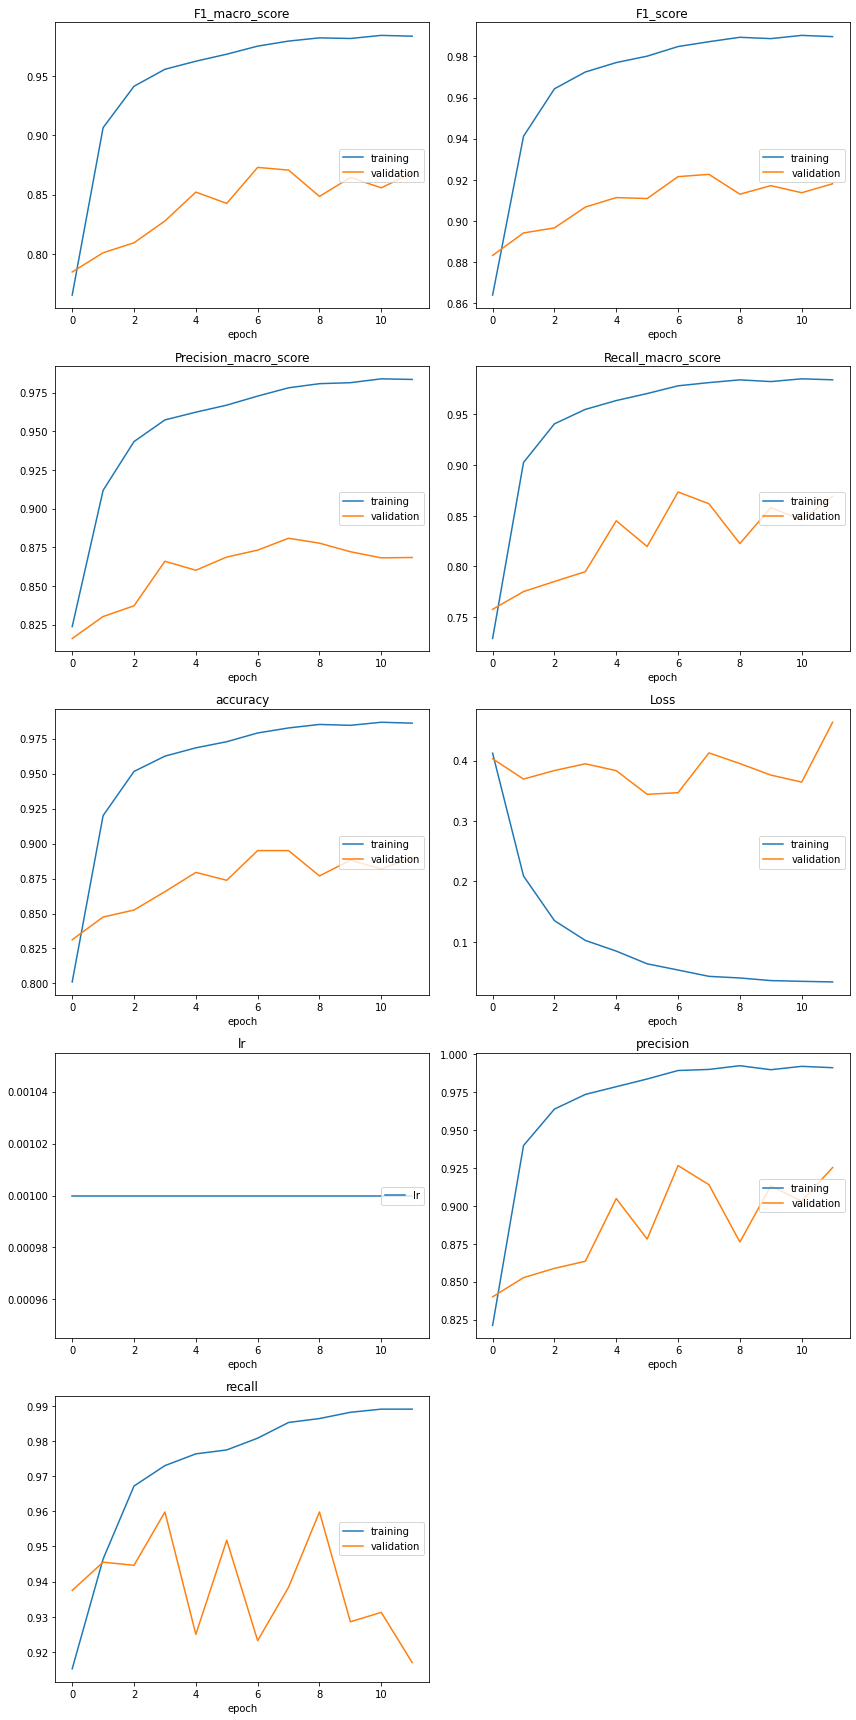

F1_macro_score
	training         	 (min:    0.765, max:    0.984, cur:    0.984)
	validation       	 (min:    0.785, max:    0.873, cur:    0.868)
F1_score
	training         	 (min:    0.864, max:    0.990, cur:    0.990)
	validation       	 (min:    0.883, max:    0.923, cur:    0.918)
Precision_macro_score
	training         	 (min:    0.824, max:    0.984, cur:    0.983)
	validation       	 (min:    0.816, max:    0.881, cur:    0.868)
Recall_macro_score
	training         	 (min:    0.729, max:    0.985, cur:    0.984)
	validation       	 (min:    0.758, max:    0.873, cur:    0.869)
accuracy
	training         	 (min:    0.801, max:    0.987, cur:    0.986)
	validation       	 (min:    0.831, max:    0.895, cur:    0.890)
Loss
	training         	 (min:    0.034, max:    0.412, cur:    0.034)
	validation       	 (min:    0.344, max:    0.463, cur:    0.463)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
precision
	training         	 (min:    0.821, max:    0.992,

In [3]:
if __name__ == '__main__':
    csv_file_path = "/content/drive/MyDrive/Dataset/DigiSay/preprocessed_df.csv"
    df = Fh.read_arabic_csv(csv_file_path)

    values = {"content": "<NONE>", 
          'top_5_word': "<NONE>",
          'alt_content_names_0':0,
          'alt_content_names_1':0,
          'alt_content_names_2':0,
          'alt_content_names_3':0,
          'alt_content_names_4':0,
          'campaign_name_freq':0,
         }

    df = df.fillna(values)

    df["domain_name_status"] = df["domain_name_status"].astype(int)
    df.drop(["link_id"], axis=1, inplace=True)
    numeric_col_name = list(df.select_dtypes(exclude = ['object']).columns)

    train, val = Utl.split_dataset(df, y_col="class", test_size=0.2, with_stratify=True, shuffle=True)
    # train, test = Utl.split_dataset(train, y_col="class", test_size=0.1, with_stratify=True, shuffle=True)

    cat_fet_cols_name = ["campaign_name", "content_name"]
    cat_fet_encode_dict, X_train_ohe = Utl.ohe_features_fit(train, cat_fet_cols_name)
    feat_directory = "/content/Weights/FeaturesEncoder"
    Utl.save_features_encoder(cat_fet_encode_dict, feat_directory)
    cat_fet_encode_dict = Utl.load_features_encoder(feat_directory)
    X_val_ohe = Utl.ohe_features_transform(val, cat_fet_encode_dict)
    using_cat_feats = True

    X_train_numeric = Utl.log_transform(train[numeric_col_name].values)
    X_val_numeric = Utl.log_transform(val[numeric_col_name].values)
    minmax_scaler = Utl.minmax_scaler_fit(X_train_numeric)
    X_train_numeric = Utl.minmax_scaler_transform(minmax_scaler, X_train_numeric)
    X_val_numeric = Utl.minmax_scaler_transform(minmax_scaler, X_val_numeric)
    path_directory = "/content/Weights"
    file_name = "minmax_scaler.pkl"
    Utl.save_model_pkl(minmax_scaler, path_directory, file_name)
    file_name = "/content/Weights/minmax_scaler.pkl"
    minmax_scaler = Utl.load_model_pkl(file_name)
    using_numeric_feats = True

    print(X_train_numeric.shape, X_train_ohe.shape)
    val_numeric_feat = None
    train_numeric_feat = None
    if using_numeric_feats and using_cat_feats:
        train_numeric_feat = Utl.horizontal_feat_concatenate_csr(X_train_ohe, X_train_numeric)
        val_numeric_feat = Utl.horizontal_feat_concatenate_csr(X_val_ohe, X_val_numeric)

    elif using_numeric_feats:
        train_numeric_feat = X_train_numeric
        val_numeric_feat = X_val_numeric

    elif using_cat_feats:
        train_numeric_feat = X_train_ohe
        val_numeric_feat = X_val_ohe

    #max_statment_len = Fe.get_max_statment_len(train, "content")
    max_statment_len = 2000

    tokenizer, vocab_size = Fe.get_tokenizer_obj(train["content"].values)
    directory = "/content/Weights/"
    tokenizer_file = "tokenizer.pkl"
    Utl.save_model_pkl(tokenizer, directory, tokenizer_file)
    tokenizer_file = "/content/Weights/tokenizer.pkl"
    tokenizer = Utl.load_model_pkl(tokenizer_file)

    X_train = Fe.tokenize_texts_to_sequences(tokenizer, train["content"].values)
    X_train = Fe.padding_sequences(X_train, max_statment_len)

    X_val = Fe.tokenize_texts_to_sequences(tokenizer, val["content"].values)
    X_val = Fe.padding_sequences(X_val, max_statment_len)

    label_encoder = Utl.get_label_encoder_obj(train["class"])
    path_directory = "/content/Weights"
    file_name = "label_encoder.pkl"
    Utl.save_model_pkl(label_encoder, path_directory, file_name)
    file_name = "/content/Weights/label_encoder.pkl"
    label_encoder = Utl.load_model_pkl(file_name)
    train["class"] = Utl.get_y_label_encoder(label_encoder, train["class"])
    val["class"] = Utl.get_y_label_encoder(label_encoder, val["class"])

    num_classes = Utl.get_nb_classes(train["class"])

    y_train = train["class"]
    y_val = val["class"]

    class_weight = Utl.get_class_weights(y_train)

    max_text_length = X_train.shape[1]
    directory = "/content/Weights/"
    LSTM_clf_params = "lstm_clf_params.json"
    params_dict = {
        "vocab_size": vocab_size,
        "max_text_length": max_text_length,
        "num_classes": 1
    }
    Fh.save_json_file(params_dict, directory, LSTM_clf_params)
    LSTM_clf_params = "/content/Weights/lstm_clf_params.json"
    params_dict = Fh.load_json_file(LSTM_clf_params)

    numeric_input_shape = train_numeric_feat.shape[1:]
    model = LSTM_clf.build_model(MAX_NB_WORDS=params_dict["vocab_size"],
                                 MAX_TEXT_LEN=params_dict["max_text_length"],
                                 input_shape=numeric_input_shape,
                                 use_only_lstm=not(using_numeric_feats and using_cat_feats),
                                 learning_rate=0.001)
    weights_path = "/content/Weights"

    if train_numeric_feat is not None and val_numeric_feat is not None:
        X_train = [X_train, train_numeric_feat.todense()]
        X_val = [X_val, val_numeric_feat.todense()]

    class_weight = None
    model, history = LSTM_clf.train_model(model,
                                          X_train, y_train,
                                          X_val, y_val,
                                          class_weight,
                                          weights_path)

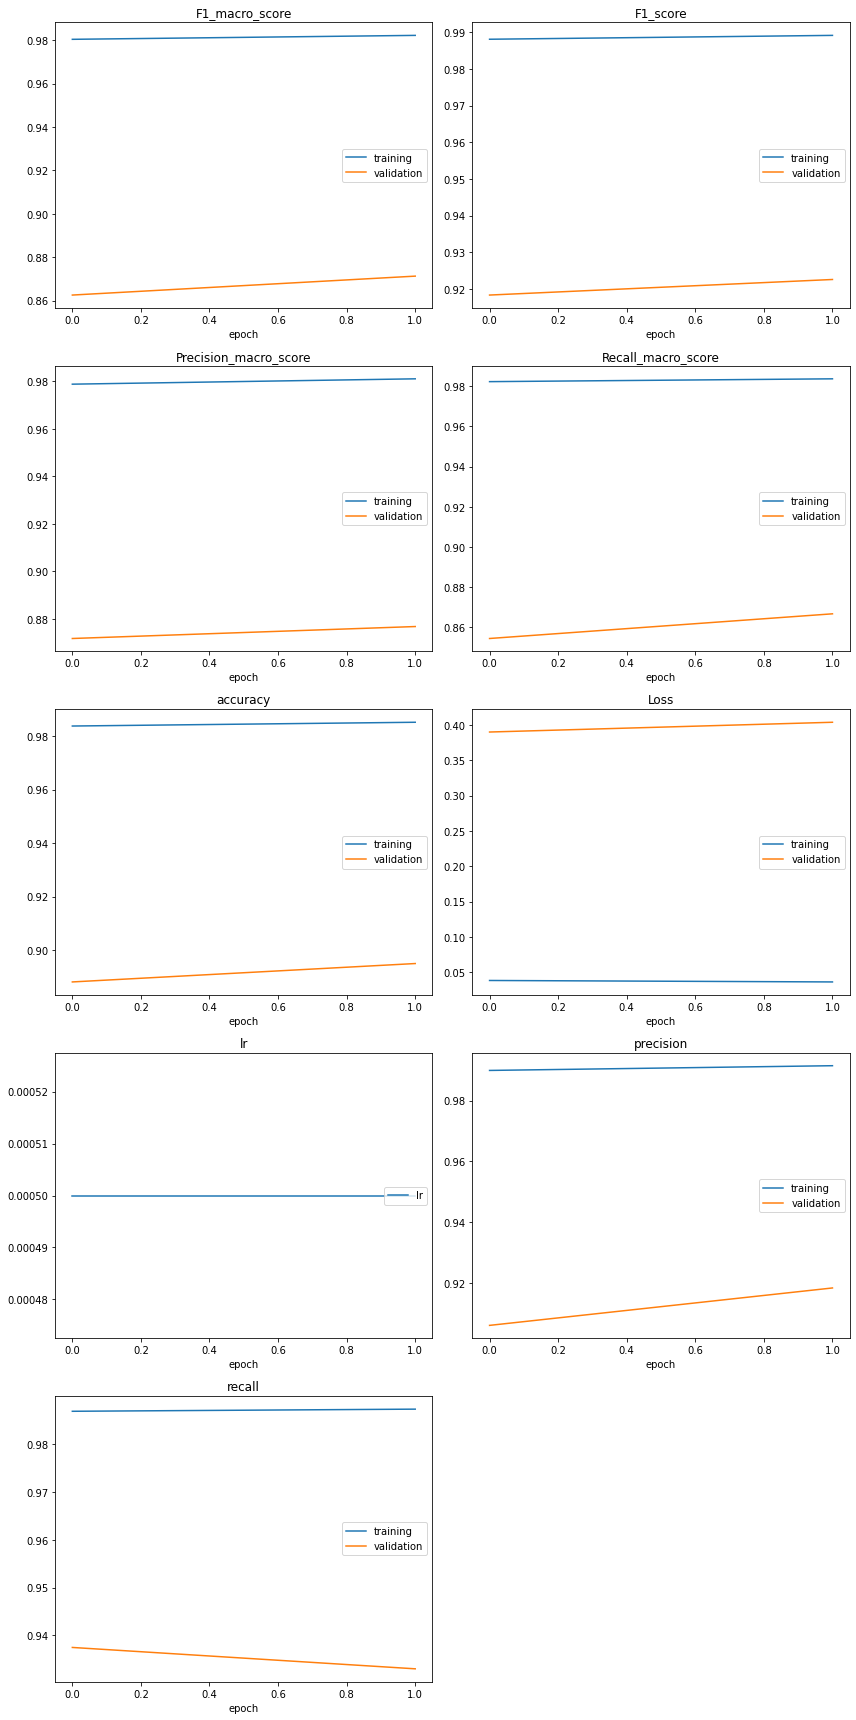

F1_macro_score
	training         	 (min:    0.980, max:    0.982, cur:    0.982)
	validation       	 (min:    0.863, max:    0.871, cur:    0.871)
F1_score
	training         	 (min:    0.988, max:    0.989, cur:    0.989)
	validation       	 (min:    0.918, max:    0.923, cur:    0.923)
Precision_macro_score
	training         	 (min:    0.979, max:    0.981, cur:    0.981)
	validation       	 (min:    0.872, max:    0.877, cur:    0.877)
Recall_macro_score
	training         	 (min:    0.982, max:    0.984, cur:    0.984)
	validation       	 (min:    0.854, max:    0.867, cur:    0.867)
accuracy
	training         	 (min:    0.984, max:    0.985, cur:    0.985)
	validation       	 (min:    0.888, max:    0.895, cur:    0.895)
Loss
	training         	 (min:    0.037, max:    0.039, cur:    0.037)
	validation       	 (min:    0.390, max:    0.404, cur:    0.404)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
precision
	training         	 (min:    0.990, max:    0.991,

In [ ]:
model, history = LSTM_clf.train_model(model,
                                      X_train, y_train,
                                      X_val, y_val,
                                      class_weight,
                                      weights_path)

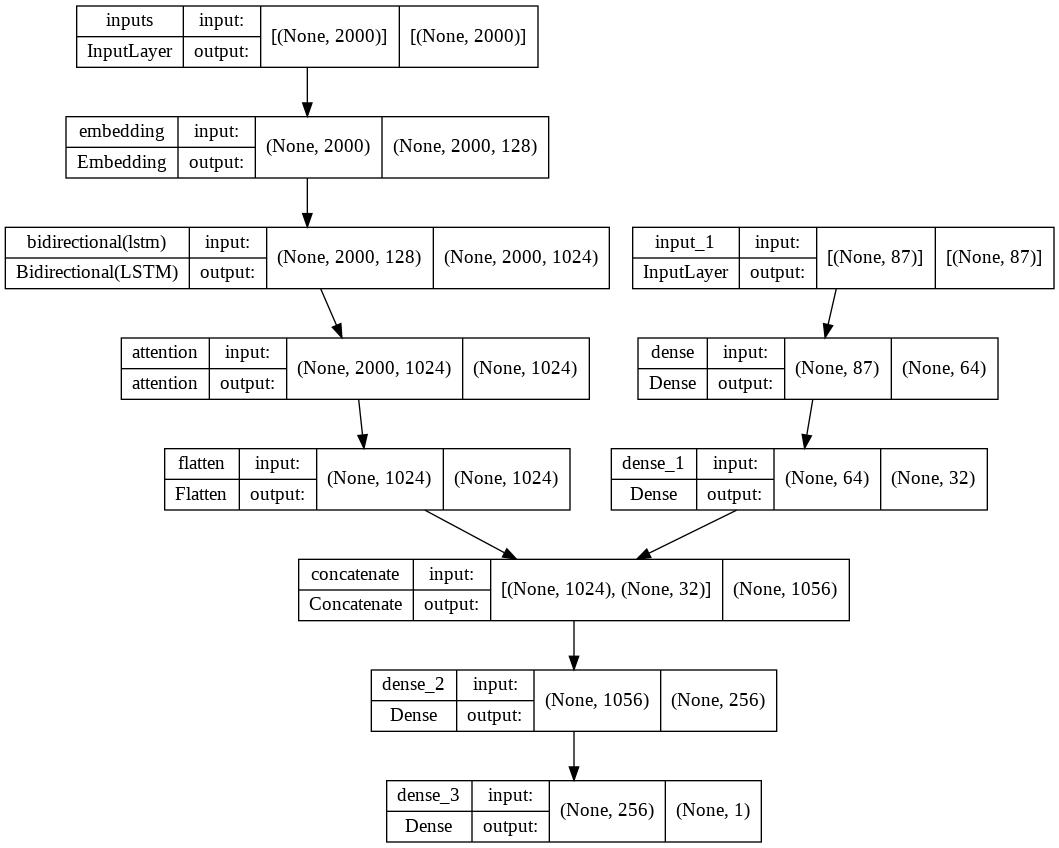

In [4]:
plot_model(model, to_file="lstm_model.jpg", show_shapes=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


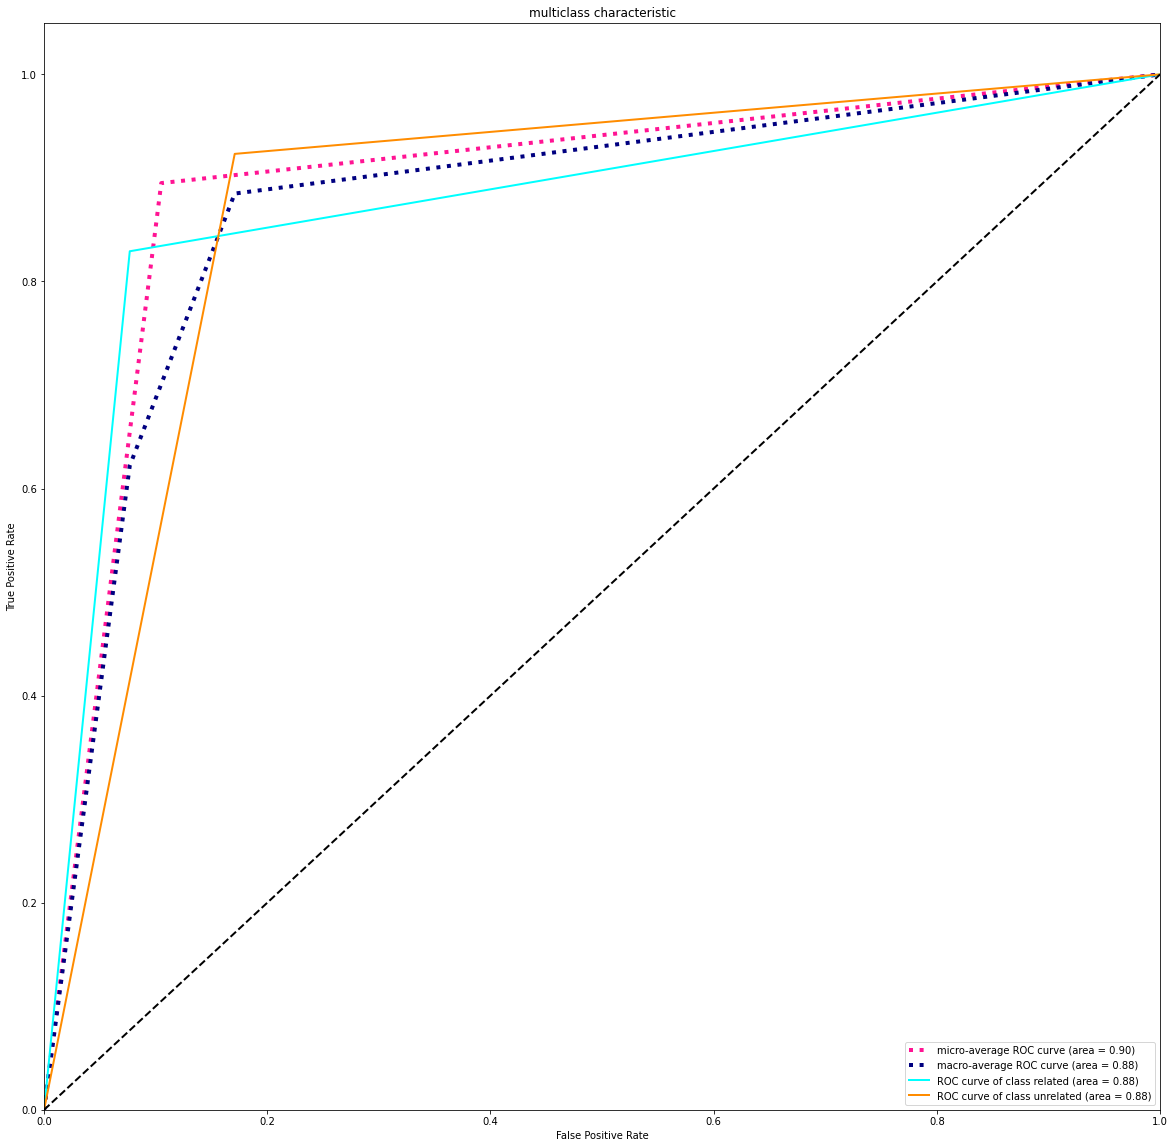

Accuracy:  0.895
Precision::  0.895
Recall::  0.895
F1_Score::  0.895

Macro precision_recall_fscore_support (macro) average
(0.8744186735389081, 0.8761904761904762, 0.8752959864607073, None)

Macro precision_recall_fscore_support (micro) average
(0.895, 0.895, 0.895, None)

Macro precision_recall_fscore_support (weighted) average
(0.8952605231197606, 0.895, 0.8951239246134548, None)

Confusion Matrix


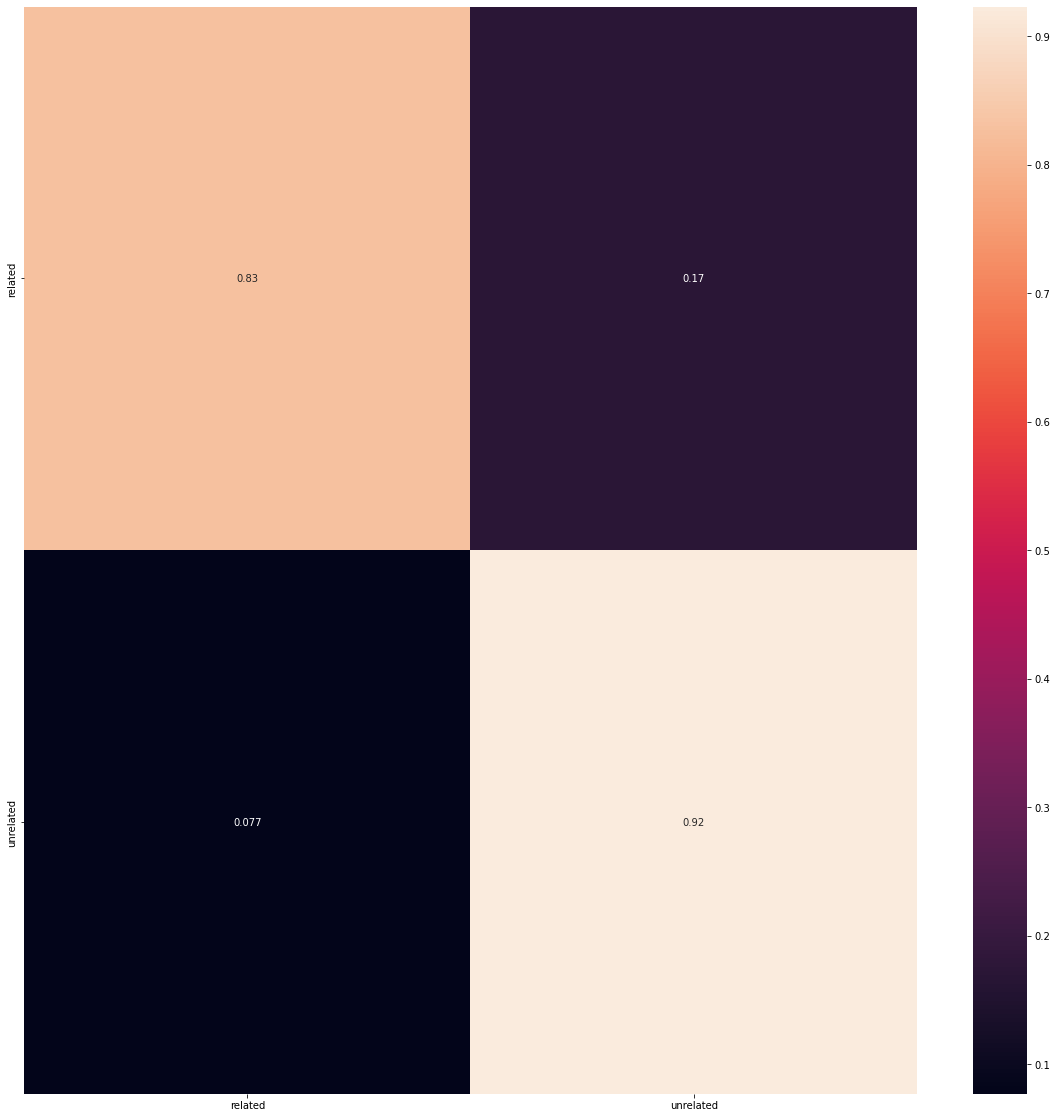


Classification Report
              precision    recall  f1-score   support

     related       0.82      0.83      0.83       480
   unrelated       0.93      0.92      0.92      1120

    accuracy                           0.90      1600
   macro avg       0.87      0.88      0.88      1600
weighted avg       0.90      0.90      0.90      1600



In [5]:
model.load_weights("/content/Weights/lstm_attention_model_weights.h5")
y_hat = model.predict(X_val)
y_hat = (y_hat>=0.5).astype(int)
Utl.get_prediction_results(y_val, y_hat, label_encoder, num_classes)
